#### Extract the number of differentially accessible regions per contrast and per cell type and produce plots displaying the number of DARs

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
plots_dir <- "../../../paper_figures/"

In [3]:
contrasts <- c("age", "fetal", "sex", "disease")
num_contrasts <- length(contrasts)

corresponding_contrast_file_names <- c("age-group_old_vs_young", "age-group_fetal_vs_young",
                              "sex_male_vs_female", "disease-binary_Y_vs_N")

cell_types <- c("Cardiomyocyte", "Endothelial", "Fibroblast", "Lymphoid", "Myeloid", "Pericyte")

q_val_threshold <- 0.05
log2_FC_threshold <- 0.5

In [4]:
extract_up_and_down_genes <- function(DE_genes_df, q_val_threshold, log2_FC_threshold) {
    # obtain the number of DE genes that are up and down regulated
    up_df <- df %>% filter(padj <= q_val_threshold) %>% filter(log2FoldChange >= log2_FC_threshold)
    down_df <- df %>% filter(padj <= q_val_threshold) %>% filter(log2FoldChange <= -log2_FC_threshold)   

    up_sig_genes <- dim(up_df)[1]
    down_sig_genes <- dim(down_df)[1]

    return(list(up_sig_genes, down_sig_genes))
}

In [5]:
de_summary_df <- data.frame(cell_type = character(),
                            contrast = character(),
                            direction = character(),
                            num_genes = integer(),
                            stringsAsFactors = FALSE)

# iterate through cell types and contrasts
for (cell_type in cell_types) {

    for (i in 1:num_contrasts) {
        contrast_file_name <- corresponding_contrast_file_names[i]
        contrast_file_path <- paste0("pydeseq2_results/", cell_type, "_", contrast_file_name, "_results.csv")

        if (file.exists(contrast_file_path)) {
            df <- read.csv(contrast_file_path, row.names = 1)
        
            num_DE_genes = extract_up_and_down_genes(DE_genes_df =  df, 
                              q_val_threshold = q_val_threshold,
                              log2_FC_threshold = log2_FC_threshold)
    
            up_genes = num_DE_genes[[1]]
            down_genes = num_DE_genes[[2]]
    
            # add rows to the summary dataframe for up and down regulated genes
            de_summary_df <- rbind(de_summary_df,
                                   data.frame(cell_type = cell_type,
                                              contrast = contrast_file_name,
                                              direction = "up",
                                              num_genes = up_genes),
                                   data.frame(cell_type = cell_type,
                                              contrast = contrast_file_name,
                                              direction = "down",
                                              num_genes = down_genes)
                                  )
        }
         else {
            print(paste0("File does not exist:", contrast_file_path))
        }
    }
}

In [6]:
head(de_summary_df)

,cell_type,contrast,direction,num_genes
,<chr>,<chr>,<chr>,<int>
1,Cardiomyocyte,age-group_old_vs_young,up,232
2,Cardiomyocyte,age-group_old_vs_young,down,469
3,Cardiomyocyte,age-group_fetal_vs_young,up,51464
4,Cardiomyocyte,age-group_fetal_vs_young,down,55650
5,Cardiomyocyte,sex_male_vs_female,up,318
6,Cardiomyocyte,sex_male_vs_female,down,86


In [7]:
unique(de_summary_df$contrast)

[1] "age-group_old_vs_young"   "age-group_fetal_vs_young"
[3] "sex_male_vs_female"       "disease-binary_Y_vs_N"

In [8]:
de_summary_df$contrast <- factor(de_summary_df$contrast, c("sex_male_vs_female", 
                                                           "age-group_old_vs_young",
                                                           "age-group_fetal_vs_young", 
                                                           "disease-binary_Y_vs_N"))

In [9]:
write.csv(de_summary_df, file = "number_of_DEGs_per_cell_type_and_contrast.csv")

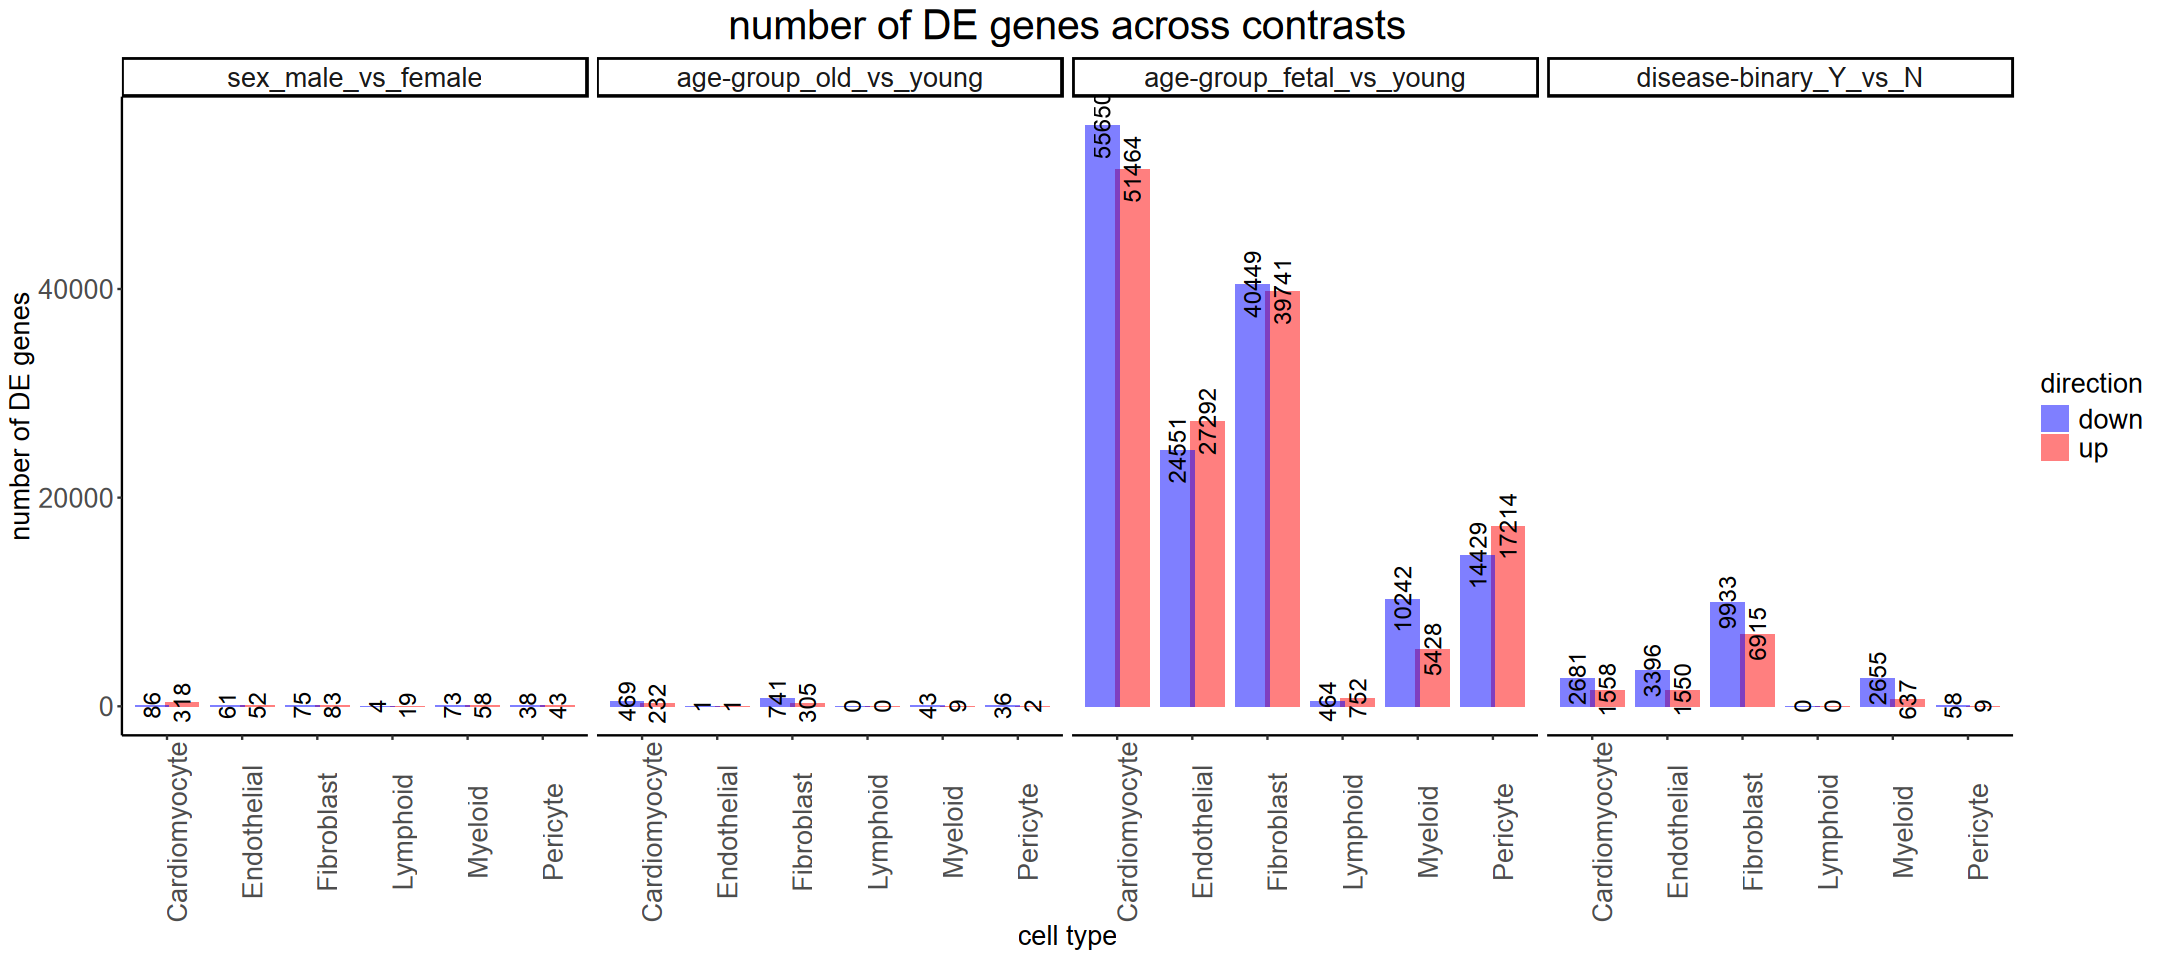

In [10]:
options(repr.plot.width = 18, repr.plot.height = 8)

p1 <- ggplot(data = de_summary_df, mapping = aes(x = cell_type, y = num_genes, fill = direction)) + 
facet_wrap(~ contrast, ncol = 4) + 
geom_bar(stat = "identity", position = position_dodge(width = 0.8), alpha = 0.5) + 
geom_text(aes(label = num_genes), 
              position = position_dodge(width = 0.8), 
              vjust = 0.5, 
              size = 5, angle = 90) + 
scale_fill_manual(values = c("up" = "red", "down" = "blue")) +
theme_classic() + theme(legend.text = element_text(size = 16), 
         legend.title = element_text(size = 16), 
         plot.title = element_text(size = 24, hjust = 0.5), 
         axis.title.x = element_text(size = 16),
         axis.title.y = element_text(size = 16),
         axis.text.x = element_text(size = 16, angle = 90),
         axis.text.y = element_text(size = 16),
         strip.text = element_text(size = 16)) + 
labs(x = "cell type", y = "number of DE genes", title = "number of DE genes across contrasts")

p1

ggsave(p1, filename = paste0(plots_dir, "snATAC_pseudobulked_DARs_across_contrasts.pdf"), width = 18, height = 8)

### Produce this plot in tabular format (heatmap)

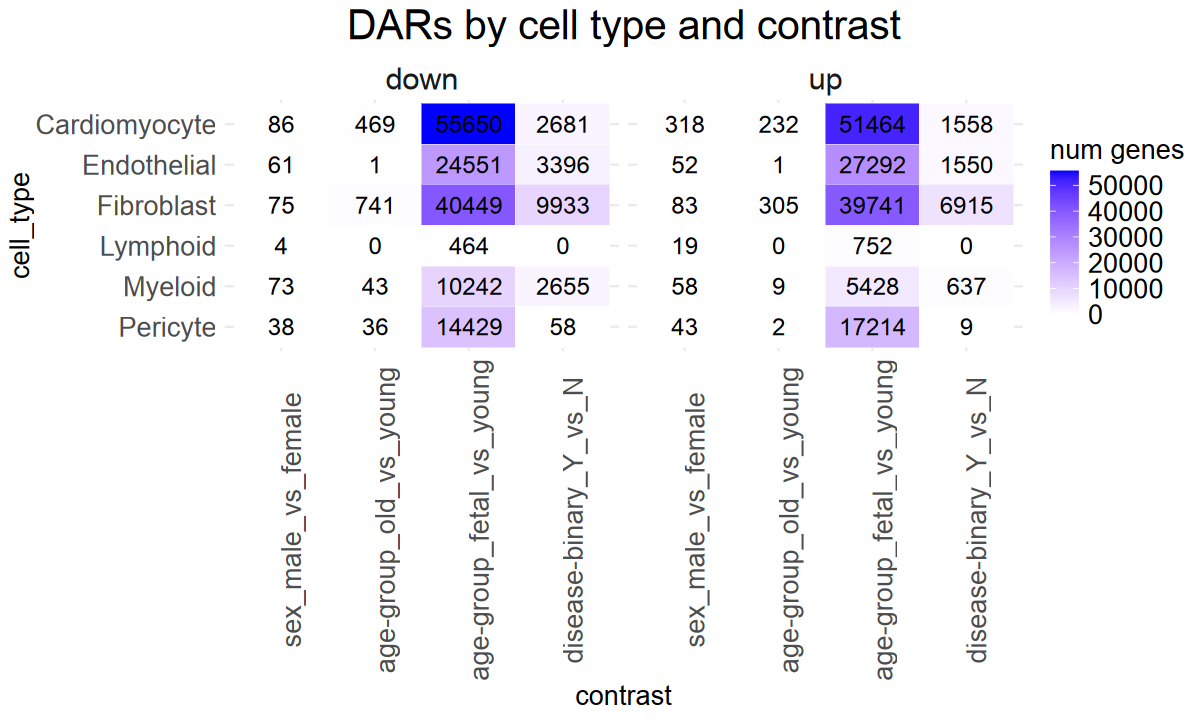

In [11]:
options(repr.plot.width = 10, repr.plot.height = 6)

# make sure the order is alphabetical first from top to bottom
de_summary_df$cell_type <- factor(de_summary_df$cell_type, levels = rev(sort(unique(de_summary_df$cell_type))))

heatmap_plot <- ggplot(de_summary_df, aes(x = contrast, y = cell_type, fill = num_genes)) +
  geom_tile(color = "white") + # heatmap tiles
  geom_text(aes(label = num_genes), color = "black", size = 5) +
  scale_fill_gradient(low = "white", high = "blue", name = "num genes") + # gradient for values
  facet_wrap(~ direction, ncol = 2) + # facet by "direction"
  theme_minimal() + # Minimal theme
  theme(
    legend.text = element_text(size = 16), 
         legend.title = element_text(size = 16), 
         plot.title = element_text(size = 24, hjust = 0.5), 
         axis.title.x = element_text(size = 16),
         axis.title.y = element_text(size = 16),
         axis.text.x = element_text(size = 16, angle = 90),
         axis.text.y = element_text(size = 16),
	 strip.text = element_text(size = 18)) +
  labs(title = "DARs by cell type and contrast")

ggsave(paste0(plots_dir, "DARs_heatmap_plot.pdf"), plot = heatmap_plot, width = 10, height = 6)

heatmap_plot